# Exercise 3: The Extended Kalman Filter (EKF) for Tracking

https://atsushisakai.github.io/PythonRobotics/#extended-kalman-filter-localization  
https://github.com/AtsushiSakai/PythonRobotics/blob/master/Localization/extended_kalman_filter/extended_kalman_filter.py

In this exercise you will:
- Learn about Kalman Filtering for localization and tracking

As a first step, let's import the python modules we need.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
from math import *
from IPython.display import display, clear_output

# pip install scipy (will also install "ipympl")
from scipy.spatial.transform import Rotation as Rot

<img width="400" height="300" src="../notebook_images/ekf_localization.png" style="padding-left: 10px; float: right;">

This example illustrates sensor fusion and localization using the Extended Kalman Filter (EKF). In the figure to the right, a robot is moving through a 2D-plane, where:

- the **blue line** is the robot's true trajectory.
- the **black line** is the *dead reckoning* trajectory.
- the **green points** are positioning observations (eg. GPS).
- the **red line** is the robot's estimated EKF trajectory.
- the **red ellipse** is the EKF estimated covariance.

### Filter design

In this simulation, the robot has a state vector consisting of 4 states at time $t$.

$
\textbf{x}_t=
\begin{bmatrix}
x_t\\
y_t\\
\phi_t\\
v_t
\end{bmatrix}
$

where,
- $x_t, y_t$ $[m,m]$ is the robot's 2D $(x_t,y_t)$ position at time $t$.
- $\phi_t$ $[rad]$ is the robot's orientation (angle) at time $t$.
- $v_t$ $[m/s]$ is the robot's velocity at time $t$.

The covariace matrix for the state is:

$
\textbf{P}_t=
\begin{bmatrix}
\sigma^2_x & 0 & 0\\
0 & \sigma^2_y & 0 & 0\\
0 & 0 & \sigma^2_{\phi} & 0\\
0 & 0 & 0 & \sigma^2_v
\end{bmatrix}
$

The robot's linear velocity and angular velocity can be controlled, so the input vector at each time step is:

$
\textbf{u}_t=
\begin{bmatrix}
v_t\\
\omega_t
\end{bmatrix}
$

Also, the robot has a Global Navigation Satellite System (GNSS) sensor (e.g. GPS), which means that the robot can observe its $(x,y)$ position at each time step.

$
\textbf{z}_t=
\begin{bmatrix}
x_t\\
y_t
\end{bmatrix}
$

The input and observation vector includes sensor noise.

### The Motion Model

The motion model is:

$
\textbf{x}_t = \textbf{F}\textbf{x}_{t-1} + \textbf{B}\textbf{u}_t
$

where,

$
\begin{equation}
\textbf{F}=
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 0
\end{bmatrix}
\end{equation}
$

$
\begin{equation}
\textbf{B}=
\begin{bmatrix}
cos(\phi)dt & 0\\
sin(\phi)dt & 0\\
0 & dt\\
1 & 0
\end{bmatrix}
\end{equation}
$

$dt$ is a time interval.

$$
\begin{equation}
\textbf{x}_t = \textbf{F}\textbf{x}_{t-1} + \textbf{B}\textbf{u}_t = 

\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 0
\end{bmatrix}

\begin{bmatrix}
x_t\\
y_t\\
\phi_t\\
v_t
\end{bmatrix}

+

\begin{bmatrix}
cos(\phi)dt & 0\\
sin(\phi)dt & 0\\
0 & dt\\
1 & 0
\end{bmatrix}
\begin{bmatrix}
v_t\\
\omega_t
\end{bmatrix}

=

\begin{bmatrix}
x_t\\
y_t\\
\phi_t\\
0
\end{bmatrix}

+

\begin{bmatrix}
v_t cos(\phi)dt\\
v_t sin(\phi)dt\\
\omega_t dt\\
v_t
\end{bmatrix}

=

\begin{bmatrix}
x_t + v_t cos(\phi)dt\\
y_t + v_t sin(\phi)dt\\
\phi_t + \omega_t dt\\
v_t
\end{bmatrix}
\end{equation}
$$

Since we have non-linear functions, we express the equation above as:

$$
\begin{equation}
\textbf{x}_t = f(\textbf{x}_{t-1}, \textbf{u}_t) = 

\begin{bmatrix}
x_t + v_t cos(\phi)dt\\
y_t + v_t sin(\phi)dt\\
\phi_t + \omega_t dt\\
v_t
\end{bmatrix}
\end{equation}
$$

Its Jacobian matrix is:

$$
\begin{equation}
\textbf{F}_t =
\frac{\partial \textbf{f}}{\partial \textbf{x}}\Bigr|_{\substack{x_{t-1}, u_t}} =
\begin{bmatrix}
\frac{dx}{dx} & \frac{dx}{dy} & \frac{dx}{d\phi} & \frac{dx}{dv}\\
\frac{dy}{dx} & \frac{dy}{dy} & \frac{dy}{d\phi} &  \frac{dy}{dv}\\
\frac{d\phi}{dx} & \frac{d\phi}{dy} & \frac{d\phi}{d\phi} &  \frac{d\phi}{dv}\\
\frac{dv}{dx} & \frac{dv}{dy} & \frac{dv}{d\phi} & \frac{dv}{dv}
\end{bmatrix}

=

\begin{bmatrix}
1 & 0 & -v sin(\phi)dt & cos(\phi)dt\\
0 & 1 & v cos(\phi)dt & sin(\phi) dt\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1\\
\end{bmatrix}
\end{equation}
$$

We also have some process noise $w_t \sim \mathcal{N}(0, \textbf{Q}_t)$ that is normally distributed with a mean of $0$ and a covariance matrix $\textbf{Q}_t$:

$$
\textbf{x}_t = f(\textbf{x}_{t-1}, \textbf{u}_t) + \textbf{w}_t
$$

$$
\textbf{Q}_t =
\begin{bmatrix}
\sigma^2_x & 0 & 0 & 0\\
0 & \sigma^2_y & 0 & 0\\
0 & 0 & \sigma^2_{\phi} & 0\\
0 & 0 & 0 & \sigma^2_v\\
\end{bmatrix}

=

\begin{bmatrix}
0.1^2 & 0 & 0 & 0\\
0 & 0.1^2 & 0 & 0\\
0 & 0 & \frac{\pi}{180}^2 & 0\\
0 & 0 & 0 & 1.0^2\\
\end{bmatrix}
$$

### The Observtion Model

The robot can get its $(x,y)$ position information from GPS.

So, the GPS observation model is:

$
\textbf{z}_{t} = \textbf{H}\textbf{x}_t
$

where,

$\begin{equation}
\textbf{H} =
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0
\end{bmatrix}
\end{equation}$

$$
\textbf{z}_{t} = \textbf{H}\textbf{x}_t =

\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0
\end{bmatrix}

\begin{bmatrix}
x_t\\
y_t\\
\phi_t\\
v_t
\end{bmatrix}

=

\begin{bmatrix}
x_t\\
y_t
\end{bmatrix}
$$

Since we have non-linear functions, we express the equation above as:

$$
\textbf{z}_{t} = h(\textbf{x}_t) = 

\begin{bmatrix}
x_t\\
y_t
\end{bmatrix}
$$

Its Jacobian matrix is:

$$
\textbf{H}_t =
\frac{\partial \textbf{h}}{\partial \textbf{x}}\Bigr|_{\substack{x_t}} =
\begin{bmatrix}
\frac{dx}{dx} & \frac{dx}{dy} & \frac{dx}{d\phi} & \frac{dx}{dv}\\
\frac{dy}{dx} & \frac{dy}{dy} & \frac{dy}{d\phi} & \frac{dy}{dv}
\end{bmatrix}

=

\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0
\end{bmatrix}
$$

We also have some measurement noise $v_t \sim \mathcal{N}(0, \textbf{R}_t)$ that is normally distributed with a mean of $0$ and a covariance matrix $\textbf{R}_t$:

$$
\textbf{z}_t = h(\textbf{x}_t) + \textbf{v}_t
$$

$$
\textbf{R}_t =
\begin{bmatrix}
\sigma^2_x & 0\\
0 & \sigma^2_y
\end{bmatrix}
 =
\begin{bmatrix}
1.0^2 & 0\\
0 & 1.0^2
\end{bmatrix}
$$

### EKF Tracking Process

**Predict**

$x_t = Fx_{t-1} + Bu_t$

$P_t = F P_{t-1} F^T + Q$

**Update**

$z_t = Hx_t$

$K = \frac{P_t H^T}{H P_t H^T + R}$

$x_t = x_t + K(z_{true} - z_t)$

$P_t = (I - K H) P_t$

---

Let's start by creating the covariance matrices $Q$ and $R$, and defining some control input noise and GPS measurement noise.

We will also simulate the system in time increments of $0.1$ seconds, for a total of $50$ seconds.

In [2]:
# Covariance and noise used for this EKF simulation

# Predicted state covariance
Q = np.diag([
    0.1,  # variance of the location on x-axis
    0.1,  # variance of the location on y-axis
    np.deg2rad(1.0),  # variance of the yaw angle
    1.0  # variance of the velocity
]) ** 2  

# Observation (x,y) position covariance
R = np.diag([1.0, 1.0]) ** 2

#  Simulation parameters for noise
INPUT_NOISE = np.diag([1.0, np.deg2rad(30.0)]) ** 2
GPS_NOISE = np.diag([0.5, 0.5]) ** 2

# Time constant ("time tick") [s]
DT = 0.1  

# Total simulation time [s]
SIM_TIME = 50.0

Next, let's create a function for the robot's motion model and its Jacobian matrix.

In [3]:
def motion_model(x, u):
    '''
    The inputs are the state vector at the previous
    time step and the current control signal.
    The output is the predicted state vector for this time step.
    '''

    F = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT],
                  [1.0, 0.0]])

    x = F @ x + B @ u

    return x


def jacob_f(x, u):
    '''
    The inputs are the state vector at the previous
    time step and the current control signal.
    The output is the Jacobian matrix for the motion model.
    '''

    v = u[0, 0]   # extract the linear velocity from the control signal
    yaw = x[2, 0] # extract the orientation from the state vector
    

    # Calculate the Jacobian matrix of the motion model for this time step
    jF = np.array([
        [1.0, 0.0, -DT * v * math.sin(yaw), DT * math.cos(yaw)],
        [0.0, 1.0, DT * v * math.cos(yaw), DT * math.sin(yaw)],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]])

    return jF

Let's also create a function for the robot's observation model and its Jacobian matrix.

In [4]:
def observation_model(x):
    '''
    The input is the predicted state vector for this time step.
    The output is the predicted observation (measurement) for this time step.
    '''

    H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    z = H @ x

    return z


def jacob_h(x=None):
    '''
    The input is the predicted state vector for this time step.
    The output is the Jacobian matrix for the observation model.
    
    Note: we don't actaully need the state vector IN THIS EXAMPLE
    to calculate the Jacobian matrix, hence I have set the default
    value for this input parameter "x" to "None".
    '''

    # Calculate the Jacobian matrix of the observation model for this time step
    jH = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    return jH

Now, let's define a function that returns the robot's control input.

In [5]:
def get_control_input():
    '''
    There is no input to this function.
    The ouput is the constant linear velocity and the
    constant angular velocity for controlling the Robot.
    '''
    v = 1.0  # [m/s]
    omega = 0.1  # [rad/s]
    
    # Enter the velocities into a column vector
    u = np.array([[v], [omega]])

    # Add noise to input
    ud = u + INPUT_NOISE @ np.random.randn(2, 1)

    return u

Let's also define a function that reads the robot's sensors. For a read robot, we would also read and return the sensor readings, but in this simulation we are going to return:
- an observation of the Robot's true position (so we can compare this with the position estimated by the EKF).
- an observation of the Robot's *dead reckoning*, i.e. wihtout any Kalman Filtering.
- and observation of the GPS sensor reading, including noise (this is the only reading the function would return for a real Robot).

In [6]:
def observation(xTrue, xd, u):
    '''
    The input is the Robot's true state vector from the previous time step,
    the Robot's dead reckoning state vector from the previous time step,
    and the current control input signal for this time step.

    The output is the Robot's true state vector for this time step,
    the current (true) sensor reading with noise added to it,
    the output is the Robot's dead reckoning state vector for this time step,
    the current control input with noise added to it.
    '''
    
    # Calculate the Robot's true state vector for this time step
    xTrue = motion_model(xTrue, u)

    # Add Gaussian random noise to the GPS reading (x,y) position
    z = observation_model(xTrue) + GPS_NOISE @ np.random.randn(2, 1)

    # Add Gaussian random noise to the control input
    ud = u + INPUT_NOISE @ np.random.randn(2, 1)

    # Calculate the Robot's dead reckoning state vector for this time step
    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud

Now we can define a function for the Kalman filtering, i.e. for one iteration:

1. Predict
2. Update

In [7]:
def ekf_estimation(x, P, z, u):
    '''
    The input is the state vector from the previous time step,
    the state covariance matrix from the previous time step,
    the current (true) sensor reading (with noise),
    and the current control input signal.
    
    The output is the predicted and corrected state vector
    and state covariance matrix for this time step.
    '''

    #############
    ## Predict ##
    #############
    
    jF = jacob_f(x, u)
    x = motion_model(x, u)    
    P = jF @ P @ jF.T + Q

    ############
    ## Update ##
    ############
    
    jH = jacob_h()
    zPred = observation_model(x) # "zPred" is the predicted sensor reading

    # Calculate the Kalman Gain
    K = P @ jH.T @ np.linalg.inv(jH @ P @ jH.T + R)
    
    #  Correct the state vector and covariance matrix
    x = x + K @ (z - zPred)
    P = (np.eye(len(x)) - K @ jH) @ P
    
    return x, P

Let's also create a function that creates an ellipse for the motion covariance, so we can visualize this in a plot.

In [8]:
def get_covariance_ellipse(xEst, PEst):
    '''
    The input is the current, corrected state vector
    and state covariance matrix for this time step.
    
    The output is the a set of (x,y) points for
    visualizing the state covariance matrix as an ellipse.
    '''

    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[1, bigind], eigvec[0, bigind])
    rot = Rot.from_euler('z', angle).as_matrix()[0:2, 0:2]
    fx = rot @ (np.array([x, y]))
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()

    return px, py

Finally, we can define a function to "drive" the simulation.

In [9]:
def main():

    # The initial time step is t=0
    time = 0.0

    # State Vector [x y yaw v]'
    # Let's set all the variables in the initial state vector to 0.
    xEst = np.zeros((4, 1))  # This is really the only state vector we need for the EKF.
    xTrue = np.zeros((4, 1)) # This state vector is only used to show the Robot's true trajectory.
    xDR = np.zeros((4, 1))   # This state vector is only used to show the Robot's "dead reckoning" trajectory.

    # State vector covariance matrix.
    # Let's set the initial covariance matrix to the identity matrix
    # (a variance of 1 for all state vector variables).
    PEst = np.eye(4)

    # We will keep a history of the three state vectors and the
    # sensor reading, so that we can plot this for each time step.
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue
    hz = np.zeros((2, 1))

    # Let's create a figure, in which we can animate the Robot's trajectory.
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1, 1, 1)

    # Simulate the system for 50 seconds, using a time step of 0.1 seconds
    while SIM_TIME >= time:
        
        # Increment the time for this time step
        time += DT 

        # Get the control input signal
        u = get_control_input() 
        
        # Make an observation (i.e. read sensors, etc.)
        xTrue, z, xDR, ud = observation(xTrue, xDR, u)

        # Perform one step of EKF estimation (tracking)
        xEst, PEst = ekf_estimation(xEst, PEst, z, ud)

        # Store the predicted state vectors and the sensor reading in our history
        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
        hz = np.hstack((hz, z))

        # Show an animation of the system's state
        
        ax.cla()       

        # Plot the GPS sensor's reading positions
        ax.plot(hz[0, :], hz[1, :], ".g")
        
        # Plot the Robot's history of positions
        # (true, dead reckoning, EKF localization estimate)
        ax.plot(hxTrue[0, :].flatten(),
                    hxTrue[1, :].flatten(), "-b")
        
        ax.plot(hxDR[0, :].flatten(),
                    hxDR[1, :].flatten(), "-k")
        
        ax.plot(hxEst[0, :].flatten(),
                    hxEst[1, :].flatten(), "-r")
        
        # Plot the state covariance ellipse
        px, py = get_covariance_ellipse(xEst, PEst)        
        ax.plot(px, py, "--r")            
        
        ax.axis('square')
        ax.grid(True)

        display(fig)    
        clear_output(wait = True)
        plt.pause(0.001)

Now, let's run the simulation.

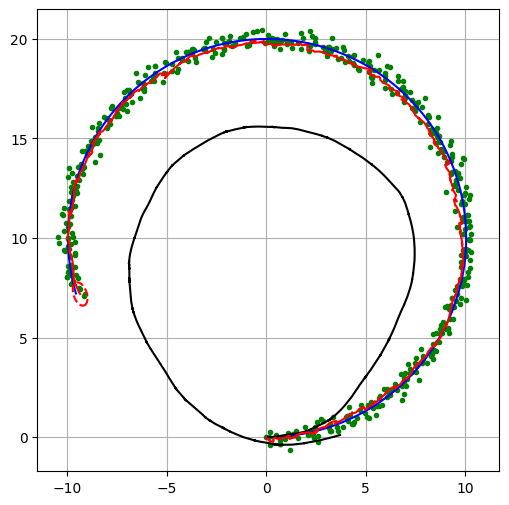

In [10]:
# Run simulation
main()